# Student details:


# Student details:
* student 1:Anna Ryvkov 321266868
* student 2:Guy Bensky 212204531

importing libs

In [1]:
import os
import kagglehub
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import glob
from PIL import Image
from collections import Counter
import requests
from io import BytesIO
from keras.layers import Conv2D

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Downloading dataset

In [2]:
# Download the dataset from Kaggle using kagglehub
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")
print("Path to dataset files:", path)

data_dir = os.path.join(path, "Garbage classification", "Garbage classification")
classes = os.listdir(data_dir)
print("Classes found:", classes)

100%|██████████| 82.0M/82.0M [00:00<00:00, 146MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/asdasdasasdas/garbage-classification/versions/2
Classes found: ['plastic', 'trash', 'cardboard', 'paper', 'glass', 'metal']


**Loading and Visualizing Dataset Classes**

removes hidden system files, lists the dataset classes, and displays random sample images from each category to verify the dataset structure.

Classes found: ['plastic', 'trash', 'cardboard', 'paper', 'glass', 'metal']


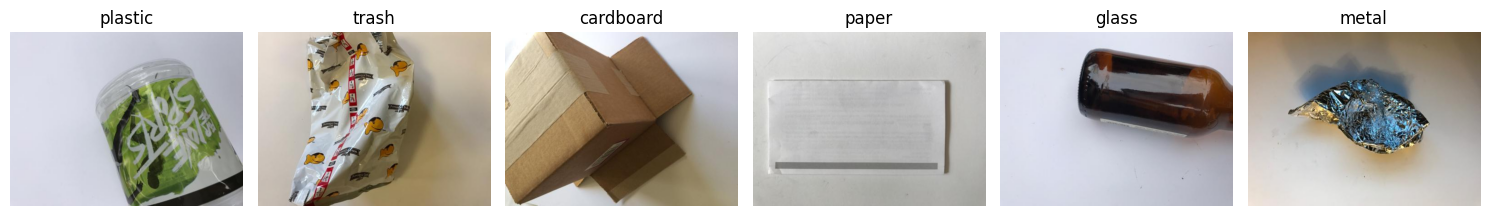

In [3]:
# Remove hidden files (e.g., .DS_Store) if any
classes = [cls for cls in classes if not cls.startswith('.')]

print("Classes found:", classes)

# Let's visualize some random images
num_classes_to_show = len(classes)
plt.figure(figsize=(15, 5))

for i, cls in enumerate(classes):
    cls_folder = os.path.join(data_dir, cls)
    image_files = glob.glob(os.path.join(cls_folder, '*'))

    if not image_files:
        continue

    # randomly select an image
    img_path = random.choice(image_files)
    image = Image.open(img_path)

    plt.subplot(1, num_classes_to_show, i+1)
    plt.imshow(image)
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()

**Data Preprocessing and Splitting into Train, Validation, and Test Sets**

This block processes dataset images, converts labels to numerical format, and splits the dataset into training (70%), validation (15%), and test (15%) sets. It ensures balanced class distribution and prints the number of images per class.

In [4]:
image_paths = []
labels = []

for cls in classes:
    cls_folder = os.path.join(data_dir, cls)
    for img_file in glob.glob(os.path.join(cls_folder, '*')):
        if img_file.lower().endswith(('png', 'jpg', 'jpeg')):
            image_paths.append(img_file)
            labels.append(cls)

# Convert labels to numerical indices
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
idx_to_class = {idx: cls_name for cls_name, idx in class_to_idx.items()}
numeric_labels = [class_to_idx[label] for label in labels]

# Train-Val-Test split (70%, 15%, 15%)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, numeric_labels, test_size=0.15, stratify=numeric_labels, random_state=42
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.1765,  # 0.15 / 0.85 = ~0.1765
    stratify=train_labels, random_state=42
)

print("Train set size:", len(train_paths))
print("Validation set size:", len(val_paths))
print("Test set size:", len(test_paths))

# Get the numeric distributions
train_dist_num = Counter(train_labels)
val_dist_num   = Counter(val_labels)
test_dist_num  = Counter(test_labels)

# Convert numeric distribution to class-name distribution
def convert_distribution_to_class_names(dist_num):

    return {idx_to_class[k]: v for k, v in dist_num.items()}

# Apply to each dataset
train_dist_named = convert_distribution_to_class_names(train_dist_num)
val_dist_named   = convert_distribution_to_class_names(val_dist_num)
test_dist_named  = convert_distribution_to_class_names(test_dist_num)

print("\nClass distribution in train set:", train_dist_named)
print("Class distribution in val set:", val_dist_named)
print("Class distribution in test set:", test_dist_named)


Train set size: 1768
Validation set size: 379
Test set size: 380

Class distribution in train set: {'metal': 286, 'trash': 95, 'glass': 351, 'cardboard': 282, 'plastic': 338, 'paper': 416}
Class distribution in val set: {'cardboard': 60, 'paper': 89, 'metal': 62, 'glass': 75, 'plastic': 72, 'trash': 21}
Class distribution in test set: {'metal': 62, 'cardboard': 61, 'paper': 89, 'glass': 75, 'plastic': 72, 'trash': 21}


**Calculating and Normalizing Class Weights to Handle Imbalance**

Calculates class weights to balance the dataset, ensuring that underrepresented classes contribute equally during training. The weights are normalized between 0.5 and 2 for stability.

In [5]:
# Calculate raw class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Normalize to range [0.5, 2]
max_weight = max(class_weights)
min_weight = min(class_weights)

normalized_weights = [
    0.5 + (w - min_weight) / (max_weight - min_weight) * (2 - 0.5) for w in class_weights
]

# Convert to dictionary
class_weights_dict = {i: weight for i, weight in enumerate(normalized_weights)}

# Print updated weights
print("Updated Class Weights (Normalized):")
for class_name, weight in zip(classes, class_weights_dict.values()):
    print(f"{class_name}: {weight:.2f}")


Updated Class Weights (Normalized):
plastic: 0.60
trash: 2.00
cardboard: 0.71
paper: 0.50
glass: 0.58
metal: 0.70


**Data Augmentation and Custom Data Generators for Training**

This block applies advanced data augmentation to enhance model generalization and implements a custom data generator that loads, processes, and augments images dynamically during training.



In [6]:
batch_size = 64
image_size = (224, 224)

train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.4,
    brightness_range=[0.5, 1.5],  # Added brightness variations
    shear_range=0.2,  # Slight distortions
    fill_mode="nearest",
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

def create_generator(datagen, paths, labels, batch_size, class_mode='categorical'):
    while True:
        # Shuffle paths and labels together
        indices = np.arange(len(paths))
        np.random.shuffle(indices)

        for start in range(0, len(paths), batch_size):
            end = min(start + batch_size, len(paths))
            batch_indices = indices[start:end]

            batch_images = []
            batch_labels_list = []
            batch_weights = []

            for idx in batch_indices:
                img_path = paths[idx]
                label = labels[idx]

                # Load image
                img = Image.open(img_path).convert('RGB')
                img = img.resize(image_size)
                img = np.array(img)

                # Convert label to one-hot
                label_one_hot = np.zeros(len(classes))
                label_one_hot[label] = 1.0

                batch_images.append(img)
                batch_labels_list.append(label_one_hot)
                batch_weights.append(class_weights_dict[label])  # Get weight for this sample

                batch_images.append(img)
                batch_labels_list.append(label_one_hot)

            batch_images = np.array(batch_images)
            batch_labels_list = np.array(batch_labels_list)


            # Apply ImageDataGenerator transformations
            flow_iter = datagen.flow(
                batch_images,
                batch_labels_list,
                batch_size=batch_size,
                shuffle=False
            )

            # Grab the augmented batch
            batch_images_aug, batch_labels_aug = next(flow_iter)

            yield batch_images_aug, batch_labels_aug

# Create the generators
train_generator = create_generator(train_datagen, train_paths, train_labels, batch_size)
val_generator   = create_generator(val_datagen,   val_paths,   val_labels,   batch_size)
test_generator  = create_generator(test_datagen,  test_paths,  test_labels,  batch_size)

train_steps = len(train_paths) // batch_size
val_steps   = len(val_paths) // batch_size
test_steps  = len(test_paths) // batch_size


**Training a Simple Baseline CNN Model**

This block builds and trains a basic CNN to establish a performance baseline for garbage classification.
The model is trained for 15 epochs and evaluated on the test set.

In [7]:
def create_baseline_cnn(input_shape=(224, 224, 3), num_classes=len(classes)):
    model = models.Sequential([
        layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

baseline_model = create_baseline_cnn()
baseline_model.summary()

# Let's train the baseline model for a few epochs
baseline_history = baseline_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=15
)

# Evaluate baseline
baseline_eval = baseline_model.evaluate(test_generator, steps=test_steps, verbose=0)
print(f"\nBaseline Model - Test Loss: {baseline_eval[0]}, Test Accuracy: {baseline_eval[1]}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 93312)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       5,972,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,977,510 (22.80 MB)

 Trainable params: 5,977,510 (22.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2331 - loss: 4.8991 - val_accuracy: 0.3562 - val_loss: 1.6032
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 992ms/step - accuracy: 0.2745 - loss: 1.7032 - val_accuracy: 0.3250 - val_loss: 1.6582
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2914 - loss: 1.6886 - val_accuracy: 0.3313 - val_loss: 1.5316
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3292 - loss: 1.6174 - val_accuracy: 0.3688 - val_loss: 1.5129
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3707 - loss: 1.5538 - val_accuracy: 0.3812 - val_loss: 1.4435
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3799 - loss: 1.5307 - val_accuracy: 0.4313 - val_loss: 1.4487
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3720 - loss: 1.5168 - val_accuracy: 0.4062 - val_loss: 1.5054
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3903 - loss: 1.5029 - val_accuracy: 0.3750 - val_lo

**Fine-Tuning MobileNetV2 for Garbage Classification**

This block loads a pre-trained MobileNetV2 model, unfreezes the last 50 layers, and adds custom classification layers. The model is compiled with a low learning rate for fine-tuning.

In [8]:
def create_mobilenetv2_model(input_shape=(224, 224, 3), num_classes=len(classes)):
    # Load the base MobileNetV2 without the top layer
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base_model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the last 50 layers for fine-tuning
    for layer in base_model.layers[-50:]:
        layer.trainable = True

    # Add a pre-processing layer
    x = base_model.output

    # Add a pooling layer
    x = GlobalAveragePooling2D()(x)

    # Add a dense layer for classification
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = Dropout(0.5)(x)

    # Output softmax layer
    output = Dense(num_classes, activation='softmax')(x)

    # Create the full model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(
        optimizer = Adam(learning_rate=5e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create and summarize the model
mobilenet_model = create_mobilenetv2_model()
mobilenet_model.summary()



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,916,934 (11.13 MB)

 Trainable params: 2,514,054 (9.59 MB)

 Non-trainable params: 402,880 (1.54 MB)

**Implementing Learning Rate Scheduling and Early Stopping**

This block adds learning rate scheduling and early stopping to optimize training efficiency. It reduces the learning rate when validation loss stops improving and stops training early to prevent overfitting.

In [9]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # stop if val_loss doesn't improve for 5 epochs
    restore_best_weights=True,
    verbose=1
)


**Implementing K-Fold Cross-Validation for Model Evaluation**

This block trains and evaluates the model across 5 different folds of the dataset, ensuring robust performance assessment by using different train-validation splits.

In [10]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

all_paths = np.array(image_paths)
all_labels = np.array(numeric_labels)

fold = 1
cv_scores = []

for train_index, val_index in kf.split(all_paths):
    print(f"\n===== Fold {fold} / {k_folds} =====")

    # Split the data
    X_train, X_val = all_paths[train_index], all_paths[val_index]
    y_train, y_val = all_labels[train_index], all_labels[val_index]

    # Create training/validation generators for this fold
    train_generator_cv = create_generator(train_datagen, X_train, y_train, batch_size)
    val_generator_cv   = create_generator(val_datagen,   X_val,   y_val,   batch_size)

    steps_train_cv = len(X_train) // batch_size
    steps_val_cv   = len(X_val) // batch_size

    # Build a new MobileNetV2 for each fold
    fold_model = create_mobilenetv2_model()

    # Train
    history_cv = fold_model.fit(
        train_generator_cv,
        steps_per_epoch=steps_train_cv,
        validation_data=val_generator_cv,
        validation_steps=steps_val_cv,
        epochs=10,
        callbacks=[reduce_lr, early_stopping],
        verbose=1
    )

    # Evaluate on the validation part of the fold
    val_eval = fold_model.evaluate(val_generator_cv, steps=steps_val_cv, verbose=0)
    print(f"Fold {fold} Validation - Loss: {val_eval[0]}, Accuracy: {val_eval[1]}")
    cv_scores.append(val_eval[1])

    fold += 1

print("\nCross-validation accuracies:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))


===== Fold 1 / 5 =====
Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.2681 - loss: 1.9200 - val_accuracy: 0.5848 - val_loss: 1.2824 - learning_rate: 5.0000e-05
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5228 - loss: 1.3163 - val_accuracy: 0.7232 - val_loss: 0.8971 - learning_rate: 5.0000e-05
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6548 - loss: 1.0013 - val_accuracy: 0.7455 - val_loss: 0.8249 - learning_rate: 5.0000e-05
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7023 - loss: 0.9100 - val_accuracy: 0.7589 - val_loss: 0.8062 - learning_rate: 5.0000e-05
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7118 - loss: 0.7922 - val_accuracy: 0.7411 - val_loss: 0.8117 - learning_rate: 5.0000e-05
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7414 - loss: 0.7827 - val_accuracy: 0.7768 - val_loss: 0.7732 - learning_rate: 5.0000e-05
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - 

**Implementing Focal Loss for Better Handling of Class Imbalance**

This block defines and applies Focal Loss, a modified version of cross-entropy that reduces the impact of well-classified samples and focuses on hard-to-classify examples, improving performance on imbalanced datasets.



In [11]:
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.sum(weight * cross_entropy, axis=-1)
    return loss

final_model = create_mobilenetv2_model()

history = final_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=15,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)


Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.2739 - loss: 1.8748 - val_accuracy: 0.5250 - val_loss: 1.3432 - learning_rate: 5.0000e-05
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 998ms/step - accuracy: 0.5169 - loss: 1.3347 - val_accuracy: 0.5813 - val_loss: 1.1499 - learning_rate: 5.0000e-05
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6056 - loss: 1.1166 - val_accuracy: 0.6750 - val_loss: 1.0456 - learning_rate: 5.0000e-05
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6549 - loss: 0.9804 - val_accuracy: 0.6375 - val_loss: 1.0570 - learning_rate: 5.0000e-05
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7150 - loss: 0.8895 - val_accuracy: 0.6375 - val_loss: 1.0603 - learning_rate: 5.0000e-05
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7431 - loss: 0.7802 - val_accuracy: 0.6938 - val_loss: 0.9225 - learning_rate: 5.0000e-05
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7432 - lo

**Evaluating Model Performance with Accuracy, Confusion Matrix, and Classification Report**

This block evaluates the final trained model on the test dataset, generates a confusion matrix to analyze classification errors, and prints a detailed classification report for each category.

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.8371 - loss: 0.5717
Test Loss: 0.592370867729187
Test Accuracy: 0.856249988079071
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


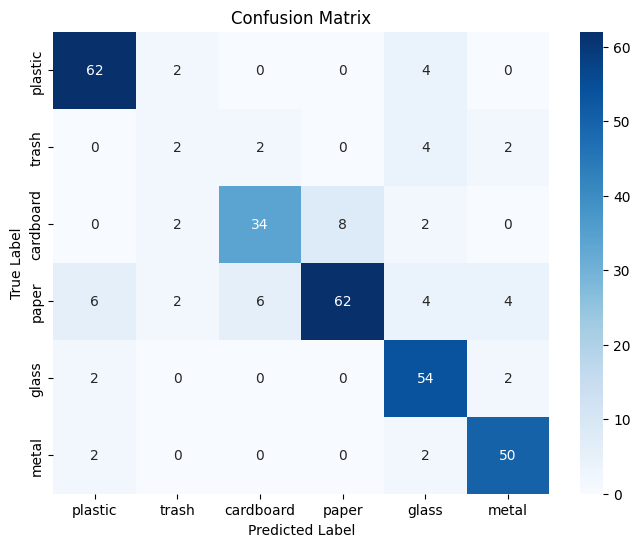


Classification Report:
              precision    recall  f1-score   support

     plastic       0.86      0.91      0.89        68
       trash       0.25      0.20      0.22        10
   cardboard       0.81      0.74      0.77        46
       paper       0.89      0.74      0.81        84
       glass       0.77      0.93      0.84        58
       metal       0.86      0.93      0.89        54

    accuracy                           0.82       320
   macro avg       0.74      0.74      0.74       320
weighted avg       0.82      0.82      0.82       320



In [12]:
test_loss, test_accuracy = final_model.evaluate(test_generator, steps=test_steps, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions for confusion matrix
test_generator_full = create_generator(test_datagen, test_paths, test_labels, batch_size)
predictions = []
true_labels = []

for _ in range(test_steps):
    x_batch, y_batch = next(test_generator_full)
    preds = final_model.predict(x_batch)
    predictions.extend(np.argmax(preds, axis=1))
    true_labels.extend(np.argmax(y_batch, axis=1))

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=classes))


**Visualizing Feature Maps of the First Convolutional Layer**

This block extracts and displays feature maps from the first convolutional layer of the trained MobileNetV2 model, helping us understand how the model interprets patterns in an input image.

Visualizing feature maps for: /root/.cache/kagglehub/datasets/asdasdasasdas/garbage-classification/versions/2/Garbage classification/Garbage classification/plastic/plastic312.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


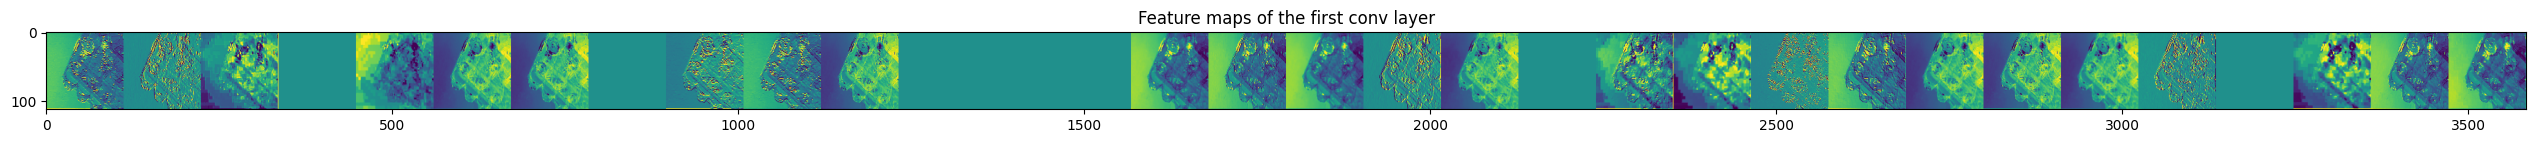

In [13]:
# Choose an image from test set
test_img_path = random.choice(test_paths)
print("Visualizing feature maps for:", test_img_path)

img = Image.open(test_img_path).convert('RGB')
img = img.resize(image_size)
img_array = np.array(img)
input_tensor = np.expand_dims(img_array, axis=0)
input_tensor = preprocess_input(input_tensor)

# Let's pick the first convolutional layer from the base MobileNetV2
layer_outputs = [layer.output for layer in final_model.layers if 'Conv' in layer.name]
activation_model = models.Model(inputs=final_model.input, outputs=layer_outputs)

activations = activation_model.predict(input_tensor)

# Visualize the feature maps of the first conv layer
first_layer_activation = activations[0]  # shape = (1, height, width, channels)
num_channels = first_layer_activation.shape[-1]
size = first_layer_activation.shape[1]

display_grid = np.zeros((size, size * num_channels))

for i in range(num_channels):
    channel_image = first_layer_activation[0, :, :, i]
    channel_image -= channel_image.mean()
    channel_image /= (channel_image.std() + 1e-5)
    channel_image *= 64
    channel_image += 128
    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
    display_grid[:, i * size : (i+1) * size] = channel_image

scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
plt.title("Feature maps of the first conv layer")
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')
plt.show()


**Testing Model Predictions on External Images**

This block downloads real-world images from URLs, processes them to match the model’s input format, and predicts their class using the trained MobileNetV2 model. The results are displayed alongside the image.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


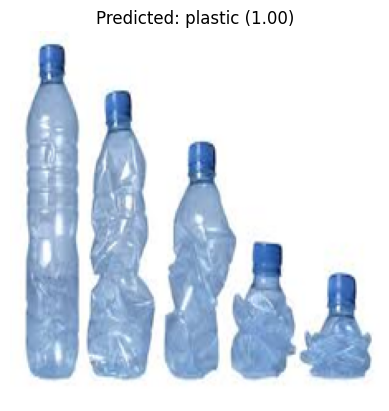

Image Label: plastic, Predicted Class: plastic, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


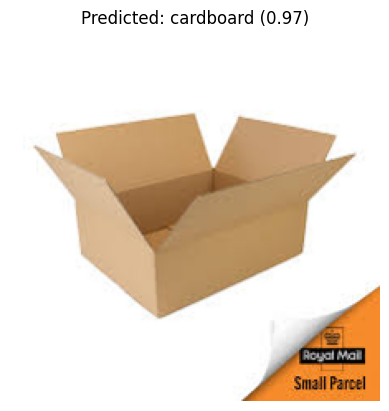

Image Label: cardboard, Predicted Class: cardboard, Confidence: 0.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


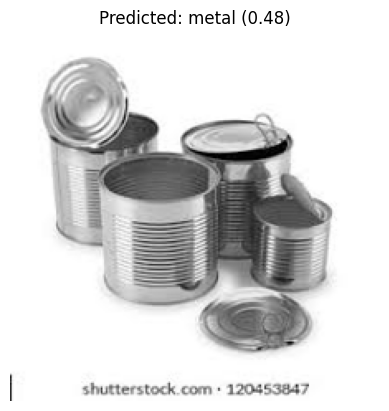

Image Label: cans, Predicted Class: metal, Confidence: 0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


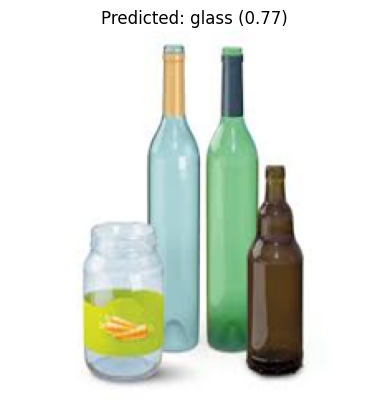

Image Label: glass, Predicted Class: glass, Confidence: 0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


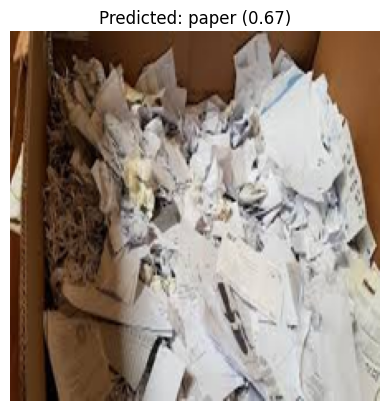

Image Label: paper, Predicted Class: paper, Confidence: 0.67


In [18]:

final_model = final_model


class_names = classes

image_urls = {
    "plastic": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS45ga7-zKDgBeHCq2D5g_GaTnmHOosFkq3Wg&s",
    "cardboard": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRv-i8jTcCrTINomdS9ubTcIH89k-qYgbsZxA&s",
    "cans": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRKzsH6x6myADVEbWbzh_DDPX1tDjkb_fiCoA&s",
    "glass": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTpTYYTZv1lFurMLQjWWIYVsuqI1XYvWTHtnA&s",
    "paper": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRBXj2X7dpNbnBg7cTqyhhHs-rvNNCgmceXIA&s",
}


img_height, img_width = 224, 224

#Processing images from downloaded URLs
def process_image_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img = img.resize((img_height, img_width)) #Fitting the image
        img_array = np.array(img)
        img_array = img_array / 255.0 # Normalizing image in range of 1-0
        img_array = np.expand_dims(img_array, axis=0)
        return img, img_array
    except Exception as e:
        print(f"Error processing image from {url}: {e}")
        return None, None

# Prediciting uploaded images
for label, url in image_urls.items():
    img, img_array = process_image_from_url(url)
    if img is None or img_array is None:
        continue

    predictions = final_model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f})")
    plt.axis("off")
    plt.show()

    print(f"Image Label: {label}, Predicted Class: {predicted_class}, Confidence: {confidence:.2f}")
